In [1]:
#melakukan import library yang dibutuhkan

import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dropout
from keras.layers import *
from math import sqrt
import math
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

#from sklearn.model_selection import train_test_split
#from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('UNVR.csv') 
df #menampilkan dataset UNVR

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-09-03,615.0,675.0,605.0,675.0,376.886749,43162500
1,2003-09-04,690.0,750.0,675.0,685.0,382.470032,82850000
2,2003-09-05,685.0,700.0,680.0,690.0,385.261932,24055000
3,2003-09-08,690.0,690.0,665.0,680.0,379.678589,18007500
4,2003-09-09,680.0,680.0,660.0,665.0,371.303162,14075000
...,...,...,...,...,...,...,...
4719,2022-08-29,4560.0,4600.0,4510.0,4580.0,4580.000000,20184000
4720,2022-08-30,4590.0,4630.0,4580.0,4580.0,4580.000000,23733200
4721,2022-08-31,4580.0,4620.0,4530.0,4590.0,4590.000000,38272000
4722,2022-09-01,4590.0,4610.0,4540.0,4540.0,4540.000000,13106400


In [3]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

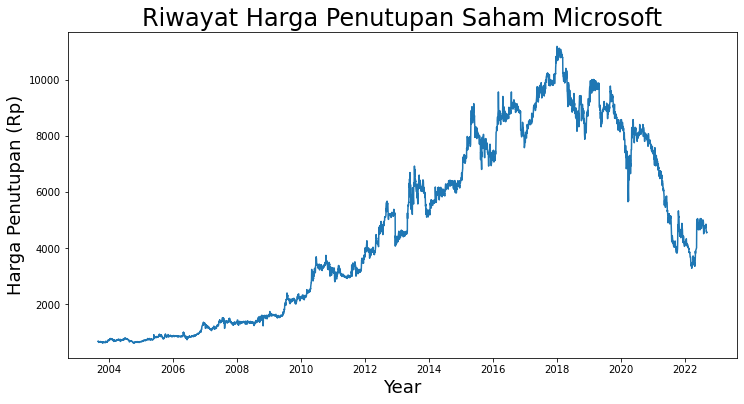

In [4]:
# Visualisasi data harga penutupan
plt.figure(figsize=(12,6))
plt.title('Riwayat Harga Penutupan Saham Microsoft', fontsize=24)
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])

plt.xlabel('Year', fontsize=18)
plt.ylabel('Harga Penutupan (Rp)', fontsize=18)
plt.show()

In [5]:
data = df.filter(['Close'])
data

,Close
0,675.0
1,685.0
2,690.0
3,680.0
4,665.0
...,...
4719,4580.0
4720,4580.0
4721,4590.0
4722,4540.0


In [6]:
data.describe()

,Close
count,4724.000000
mean,4728.277942
std,3208.212201
min,620.000000
25%,1380.000000
50%,4410.000000
75%,7925.000000
max,11180.000000


In [7]:
data_min = min(df['Close'])
data_min

620.0

In [8]:
data_max = max(df['Close'])
data_max

11180.0

In [9]:
data_len = data.values
data_len

array([[ 675.],
       [ 685.],
       [ 690.],
       ...,
       [4590.],
       [4540.],
       [4550.]])

In [10]:
# Normalisasi data dengan range (0 - 1)
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(data_len)
scaled_data

array([[0.00520833],
       [0.0061553 ],
       [0.00662879],
       ...,
       [0.37594697],
       [0.37121212],
       [0.37215909]])

In [11]:
# Split dataset
training_data = scaled_data[0:int(len(scaled_data) * 0.8)]
test_data = scaled_data[int(len(scaled_data) * 0.8):]

In [12]:
len(training_data)

3779

In [13]:
len(test_data)

945

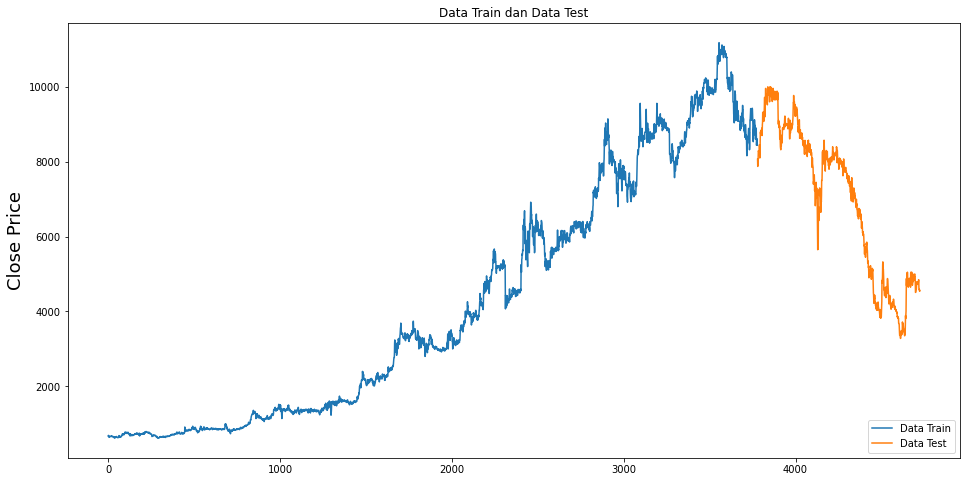

In [14]:
df_train = data[0:int(len(data)*0.8)]
df_test = data[int(len(data)*0.8):]

# plot the data
# Visualisasi data
plt.figure(figsize=(16,8))
plt.title('Data Train dan Data Test')
plt.ylabel('Close Price', fontsize=18)
plt.plot(df_train)
plt.plot(df_test)

plt.legend(['Data Train', 'Data Test'], loc='lower right')
plt.show()

In [15]:
#Parameter LSTM
timestep = 60
unit_neuron = 50
epoch = 100
batch = 32

In [16]:
# membuat struktur data X_train dengan 60 timesteps
X_train = []
y_train = []
for i in range(timestep, len(training_data)):   
    X_train.append(training_data[i-timestep:i, 0])
    y_train.append(training_data[i, 0])  
    if i <= timestep:
      print(X_train)
      print(y_train)
      print()

[array([0.00520833, 0.0061553 , 0.00662879, 0.00568182, 0.00426136,
       0.00189394, 0.00189394, 0.00378788, 0.00284091, 0.00426136,
       0.00426136, 0.00378788, 0.00378788, 0.00378788, 0.00378788,
       0.00426136, 0.00473485, 0.00426136, 0.00378788, 0.00473485,
       0.00426136, 0.00473485, 0.00426136, 0.00378788, 0.00426136,
       0.00378788, 0.00378788, 0.00331439, 0.00378788, 0.00378788,
       0.00284091, 0.00284091, 0.00331439, 0.00284091, 0.00284091,
       0.00189394, 0.        , 0.00236742, 0.00236742, 0.00236742,
       0.00142045, 0.00047348, 0.00236742, 0.00189394, 0.00284091,
       0.00189394, 0.00236742, 0.00284091, 0.00378788, 0.00378788,
       0.00331439, 0.00236742, 0.00189394, 0.00142045, 0.00142045,
       0.00094697, 0.00094697, 0.00142045, 0.00142045, 0.00142045])]
[0.0014204545454545442]



In [17]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3719, 60, 1)

In [19]:
from keras import backend as K
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))                                           
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [20]:
model_LSTM = Sequential()

#Adding the first LSTM  and some Dropout regularisation
model_LSTM.add(LSTM(units = unit_neuron, return_sequences = True, input_shape = (X_train.shape [1], 1)))
model_LSTM.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = unit_neuron, return_sequences = True))
model_LSTM.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = unit_neuron, return_sequences = True))
model_LSTM.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = unit_neuron))
model_LSTM.add(Dropout(0.2))

# Adding the output layer
model_LSTM.add(Dense(1))

#Compiling the LSTM
model_LSTM.compile(optimizer = 'adam', 
              loss = 'mean_absolute_error', 
              metrics=[r2_keras])

In [21]:
# Fitting LSTM ke data train
model_LSTM.fit(X_train, y_train, epochs = epoch, batch_size = batch)

Epoch 1/100
117/117 [==============================] - 36s 136ms/step - loss: 0.0599 - r2_keras: 0.8652
Epoch 2/100
117/117 [==============================] - 15s 129ms/step - loss: 0.0323 - r2_keras: 0.9707
Epoch 3/100
117/117 [==============================] - 15s 130ms/step - loss: 0.0307 - r2_keras: 0.9741
Epoch 4/100
117/117 [==============================] - 15s 129ms/step - loss: 0.0304 - r2_keras: 0.9747
Epoch 5/100
117/117 [==============================] - 15s 129ms/step - loss: 0.0279 - r2_keras: 0.9772
Epoch 6/100
117/117 [==============================] - 15s 131ms/step - loss: 0.0288 - r2_keras: 0.9775
Epoch 7/100
117/117 [==============================] - 17s 145ms/step - loss: 0.0291 - r2_keras: 0.9786
Epoch 8/100
117/117 [==============================] - 15s 129ms/step - loss: 0.0274 - r2_keras: 0.9788
Epoch 9/100
117/117 [==============================] - 15s 130ms/step - loss: 0.0263 - r2_keras: 0.9805
Epoch 10/100
117/117 [==============================] - 15s 130m

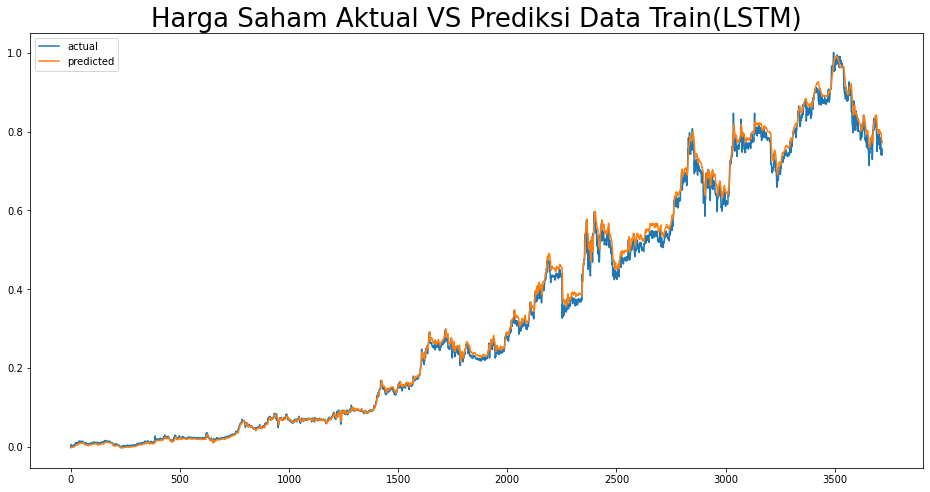

In [22]:
plt.figure(figsize=(16,8))
plt.title('Harga Saham Aktual VS Prediksi Data Train(LSTM)', fontsize=26)
plt.plot(y_train, label = "actual")
plt.plot(model_LSTM.predict(X_train), label = "predicted")
plt.legend()
plt.show()

In [23]:
# buat varibel penampung model RNN
model_RNN = Sequential()

#Adding the first SimpleRNN  and some Dropout regularisation
model_RNN.add(SimpleRNN(units = unit_neuron, return_sequences = True, input_shape = (X_train.shape [1], 1)))
model_RNN.add(Dropout(0.2))

# Adding a second SimpleRNN layer and some Dropout regularisation
model_RNN.add(SimpleRNN(units = unit_neuron, return_sequences = True))
model_RNN.add(Dropout(0.2))

# Adding a third SimpleRNN layer and some Dropout regularisation
model_RNN.add(SimpleRNN(units = unit_neuron, return_sequences = True))
model_RNN.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_RNN.add(SimpleRNN(units = unit_neuron))
model_RNN.add(Dropout(0.2))

# Adding the output layer
model_RNN.add(Dense(1))

#Compiling the LSTM
model_RNN.compile(optimizer = 'adam', 
              loss = 'mean_absolute_error', 
              metrics=[r2_keras])

In [24]:
# Fitting RNN ke data train
model_RNN.fit(X_train, y_train, epochs = epoch, batch_size = batch)

Epoch 1/100
117/117 [==============================] - 11s 60ms/step - loss: 0.4364 - r2_keras: -2.5463
Epoch 2/100
117/117 [==============================] - 7s 60ms/step - loss: 0.2439 - r2_keras: -0.1210
Epoch 3/100
117/117 [==============================] - 7s 59ms/step - loss: 0.1363 - r2_keras: 0.5591
Epoch 4/100
117/117 [==============================] - 7s 60ms/step - loss: 0.0933 - r2_keras: 0.7777
Epoch 5/100
117/117 [==============================] - 7s 59ms/step - loss: 0.0746 - r2_keras: 0.8527
Epoch 6/100
117/117 [==============================] - 7s 59ms/step - loss: 0.0598 - r2_keras: 0.9074
Epoch 7/100
117/117 [==============================] - 7s 59ms/step - loss: 0.0522 - r2_keras: 0.9303
Epoch 8/100
117/117 [==============================] - 7s 58ms/step - loss: 0.0463 - r2_keras: 0.9418
Epoch 9/100
117/117 [==============================] - 7s 59ms/step - loss: 0.0416 - r2_keras: 0.9543
Epoch 10/100
117/117 [==============================] - 7s 60ms/step - loss: 0.

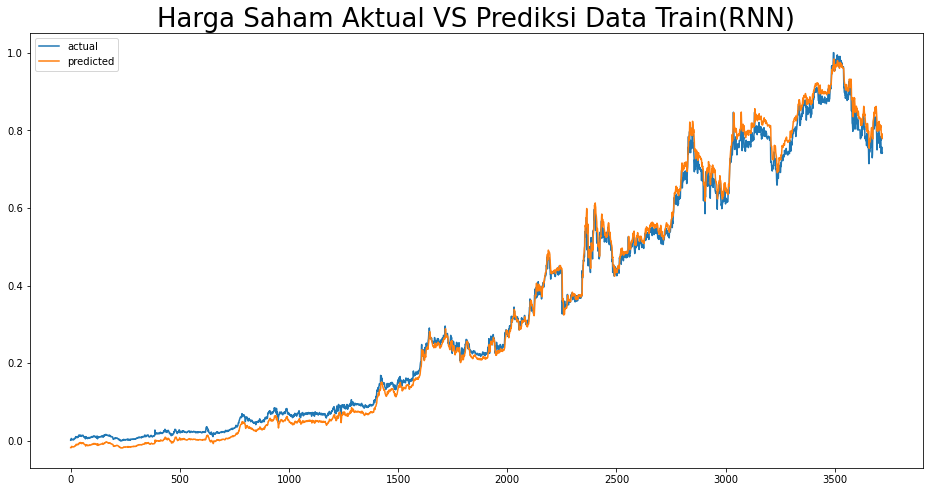

In [25]:
plt.figure(figsize=(16,8))
plt.title('Harga Saham Aktual VS Prediksi Data Train(RNN)', fontsize=26)
plt.plot(y_train, label = "actual")
plt.plot(model_RNN.predict(X_train), label = "predicted")
plt.legend()
plt.show()

In [26]:
total_data = pd.concat((df_train, df_test), axis=0)
inputs = total_data[len(total_data) - len(df_test) - timestep:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(len(inputs))

1005


In [27]:
# membuat struktur data X_test dengan 60 timesteps
X_test = []
y_test = []
for i in range(timestep, len(inputs)):
  X_test.append(inputs[i-timestep:i, 0])
  if i <= timestep:
    print(X_test)
    print()

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

[array([0.74668561, 0.74337121, 0.74810606, 0.74810606, 0.76231061,
       0.75568182, 0.76893939, 0.77793561, 0.78314394, 0.78030303,
       0.7717803 , 0.76846591, 0.77414773, 0.72916667, 0.73816288,
       0.78361742, 0.80350379, 0.80350379, 0.81486742, 0.82291667,
       0.83333333, 0.81344697, 0.80350379, 0.81628788, 0.82433712,
       0.83285985, 0.83285985, 0.8125    , 0.81392045, 0.8342803 ,
       0.83191288, 0.81818182, 0.80823864, 0.7907197 , 0.7561553 ,
       0.74952652, 0.77840909, 0.78219697, 0.79166667, 0.77651515,
       0.78030303, 0.76704545, 0.80492424, 0.79356061, 0.78598485,
       0.7907197 , 0.78361742, 0.78409091, 0.75568182, 0.78030303,
       0.77793561, 0.77367424, 0.78409091, 0.75994318, 0.7405303 ,
       0.75047348, 0.75710227, 0.75568182, 0.7405303 , 0.74242424])]



In [28]:
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(945, 60, 1)

In [29]:
predicted_LSTM = model_LSTM.predict(X_test)
predicted_LSTM = sc.inverse_transform(
    predicted_LSTM)
print(len(predicted_LSTM))

945


In [30]:
predicted_RNN = model_RNN.predict(X_test)
predicted_RNN = sc.inverse_transform(
    predicted_RNN)
print(len(predicted_RNN))

945


In [31]:
predictionLSTM = np.array(predicted_LSTM)
predictionRNN = np.array(predicted_RNN)
df_hasil = pd.DataFrame()
df_hasil['Real Price'] = df_test['Close'].reset_index(drop = True)
df_hasil['Prediction LSTM'] = predictionLSTM
df_hasil['Prediction RNN'] = predictionRNN
df_hasil

,Real Price,Prediction LSTM,Prediction RNN
0,8065.0,8734.052734,8775.239258
1,7875.0,8613.247070,8560.471680
2,7990.0,8457.843750,8351.792969
3,8000.0,8358.924805,8358.291016
4,8220.0,8310.946289,8359.679688
...,...,...,...
940,4580.0,4958.629883,4753.942383
941,4580.0,4876.233398,4668.181641
942,4590.0,4805.312012,4656.586914
943,4540.0,4769.444336,4658.923828


In [32]:
#Menyimpan tabel hasil dari prediksi 

# df_hasil.to_excel("datatest_stock(60neuron).xlsx")

In [33]:
# Besar nilai kesalahan 
mae_lstm = np.mean(np.abs((df_hasil['Real Price'] - 
                       df_hasil['Prediction LSTM'])))

mae_rnn = np.mean(np.abs((df_hasil['Real Price'] - 
                       df_hasil['Prediction RNN'])))

print('Mean Absolute Error Model LSTM : ' "{:.4f}".format(mae_lstm))
print('Mean Absolute Error Model RNN : ' "{:.4f}".format(mae_rnn))

Mean Absolute Error Model LSTM : 231.1011
Mean Absolute Error Model RNN : 233.8674


In [34]:
# Besar nilai kesalahan 
mape_lstm = np.mean(np.abs((df_hasil['Real Price'] - 
                       df_hasil['Prediction LSTM'])/df_hasil['Real Price'])) * 100

mape_rnn = np.mean(np.abs((df_hasil['Real Price'] - 
                       df_hasil['Prediction RNN'])/df_hasil['Real Price'])) * 100

print('Mean Absolute Percentage Error Model LSTM : ' "{:.3f}".format(mape_lstm)+'%')
print('Mean Absolute Percentage Error Model RNN : ' "{:.3f}".format(mape_rnn)+'%')

Mean Absolute Percentage Error Model LSTM : 3.646%
Mean Absolute Percentage Error Model RNN : 3.303%


In [35]:
# Besar nilai akurasi dengan R Squared
r2_lstm = r2_score(df_hasil['Real Price'], df_hasil['Prediction LSTM'])
r2_lstm = r2_lstm * 100

r2_rnn = r2_score(df_hasil['Real Price'], df_hasil['Prediction RNN'])
r2_rnn = r2_rnn * 100

print ('Skor Akurasi (R Squared) Model LSTM : ' "{:.2f}".format(r2_lstm)+' %')
print ('Skor Akurasi (R Squared) Model RNN : ' "{:.2f}".format(r2_rnn)+' %')

Skor Akurasi (R Squared) Model LSTM : 98.19 %
Skor Akurasi (R Squared) Model RNN : 98.02 %


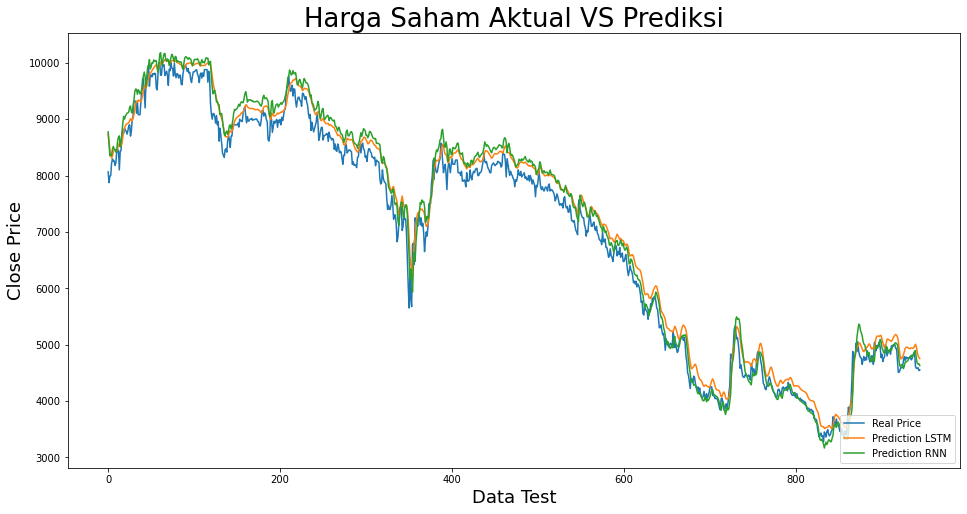

In [36]:
# Visualisasi prediksi
plt.figure(figsize=(16,8))
plt.title('Harga Saham Aktual VS Prediksi', fontsize=26)
plt.xlabel('Data Test', fontsize=18)
plt.ylabel('Close Price', fontsize=18)

plt.plot(df_hasil['Real Price'])
plt.plot(df_hasil['Prediction LSTM'])
plt.plot(df_hasil['Prediction RNN'])
plt.legend(['Real Price', 'Prediction LSTM', 'Prediction RNN'], loc='lower right')
plt.show()

In [37]:
# Prediksi 1 hari berikutnya pada 12 Juli 2021
real_data = [inputs[len(inputs) - timestep:len(inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], 
                                   real_data.shape[1],1))

prediction_LSTM = model_LSTM.predict(real_data)
prediction_LSTM = sc.inverse_transform(prediction_LSTM)

prediction_RNN = model_RNN.predict(real_data)
prediction_RNN = sc.inverse_transform(prediction_RNN)
print(f"Prediksi harga penutupan saham untuk 23 November 2021 Model LSTM : {prediction_LSTM}")
print(f"Prediksi harga penutupan saham untuk 23 November 2021 Model RNN : {prediction_RNN}")

Prediksi harga penutupan saham untuk 23 November 2021 Model LSTM : [[4750.539]]
Prediksi harga penutupan saham untuk 23 November 2021 Model RNN : [[4582.924]]
